# Fatec Deputado Ary Fossen - Jundiaí
# **Ciência de Dados - 4º Semestre**
# **Banco de Dados**
# **AVALIAÇÃO P2**

---

**Alunos:**

ALEXANDR DA FONSECA - RA:

ANDRE SANTOS DE OLIVEIRA - RA: 1141352413044

CARLOS EDUARDO PEREIRA DE REZENDE - RA: 1141352413035

MATHEUS


# **Consultas Analíticas**

Você precisa criar 5 consultas SQL respondendo perguntas de negócio.

Tipos obrigatórios de consulta:

1. Análise Temporal (linha do tempo)

-- Exemplo: Vendas por mês
SELECT
  d.year, d.month,
  SUM(f.revenue) as total_vendas
FROM fact_sales f
JOIN dim_date d ON f.date_key = d.date_key
GROUP BY d.year, d.month
ORDER BY d.year, d.month;
Mostra como as vendas evoluem ao longo do tempo

2. Ranking / TOP N (os melhores/piores)

-- Exemplo: Top 10 produtos mais vendidos
SELECT
  p.product_name,
  SUM(f.revenue) as total
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
GROUP BY p.product_name
ORDER BY total DESC
LIMIT 10;
Identifica os produtos campeões de venda

3. Agregação Multidimensional (várias perspectivas)

-- Exemplo: Vendas por categoria E por estado
SELECT
  p.category,
  c.customer_state,
  COUNT(*) as qtd_vendas,
  AVG(f.revenue) as ticket_medio
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
JOIN dim_customer c ON f.customer_key = c.customer_key
GROUP BY p.category, c.customer_state;
Cruza informações: qual categoria vende mais em qual estado?

4. Análise de Cohort / Retenção (comportamento ao longo do tempo)

-- Exemplo: Quantos clientes voltaram a comprar?
SELECT
  first_purchase_month,
  COUNT(DISTINCT customer_id) as total_clientes
FROM (
  SELECT customer_id, MIN(purchase_date) as first_purchase_month
  FROM orders
  GROUP BY customer_id
)
GROUP BY first_purchase_month;
Entende fidelização de clientes

5. KPI (indicador-chave de negócio)

-- Exemplo: Ticket médio por estado
SELECT
  c.customer_state,
  AVG(f.revenue) as ticket_medio,
  COUNT(*) as qtd_pedidos
FROM fact_sales f
JOIN dim_customer c ON f.customer_key = c.customer_key
GROUP BY c.customer_state
ORDER BY ticket_medio DESC;
Métrica importante para o negócio

Como será avaliado:

5 consultas funcionando corretamente
Usa JOINs, GROUP BY, funções de agregação
Resultados fazem sentido para o negócio
Comentários explicando o que cada query faz
Executa em menos de 30 segundos

Faça upload do arquivo ZIP contendo os CSVs da base Olist:


Saving olist_sellers_dataset.zip to olist_sellers_dataset.zip
Bases carregadas com sucesso!


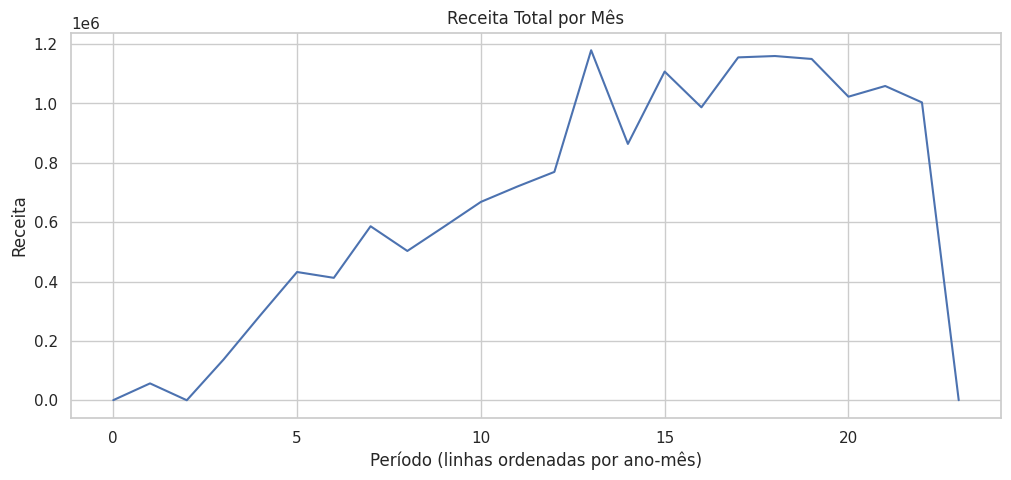

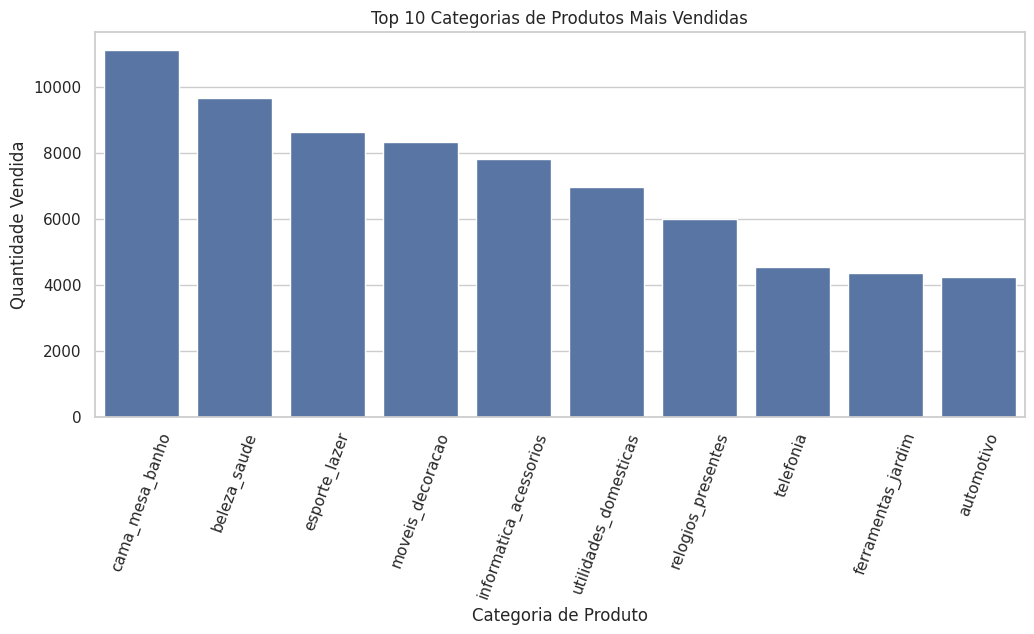

Tabela Categoria x Estado:


,product_category_name,customer_state,qtd_vendas,ticket_medio
0,agro_industria_e_comercio,AL,1,1518.550000
1,agro_industria_e_comercio,AP,1,657.610000
2,agro_industria_e_comercio,BA,5,498.896000
3,agro_industria_e_comercio,CE,6,104.031667
4,agro_industria_e_comercio,ES,2,243.585000
5,agro_industria_e_comercio,GO,7,356.114286
6,agro_industria_e_comercio,MA,1,614.630000
7,agro_industria_e_comercio,MG,21,602.927619
8,agro_industria_e_comercio,MS,3,198.056667
9,agro_industria_e_comercio,MT,2,318.225000


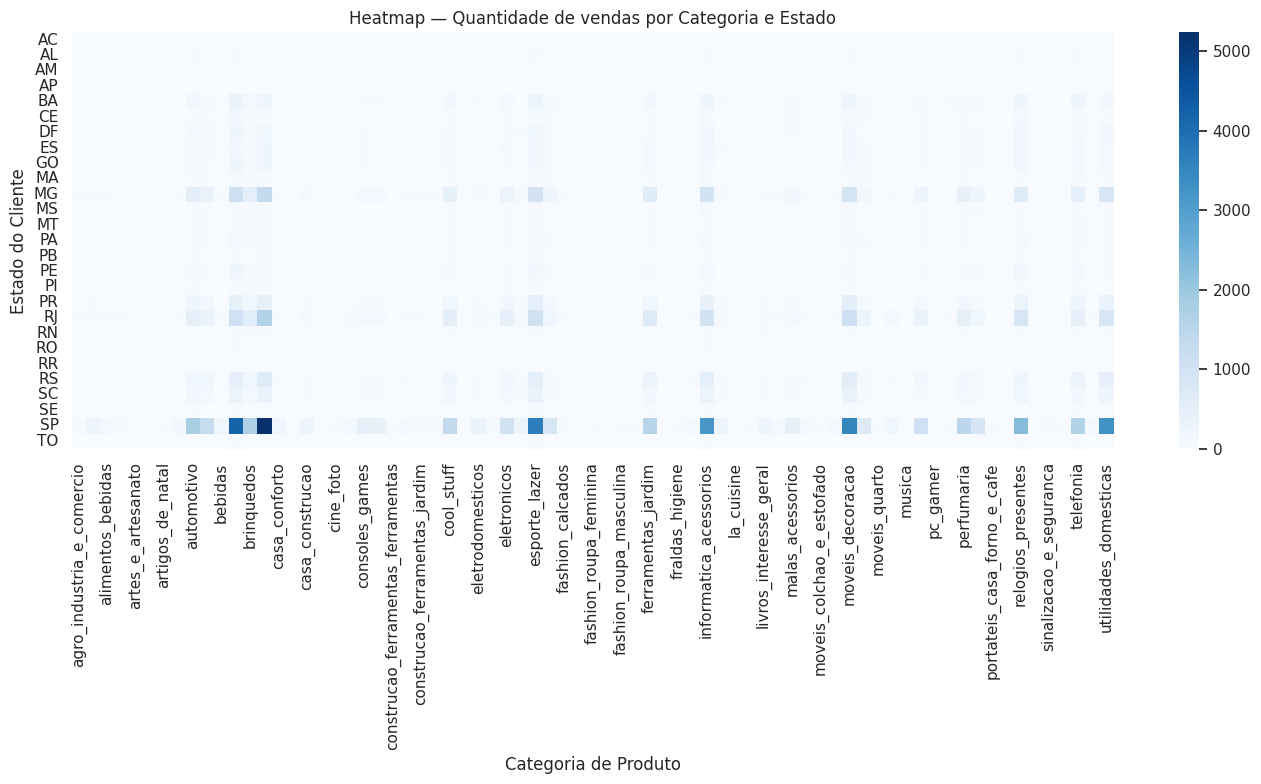

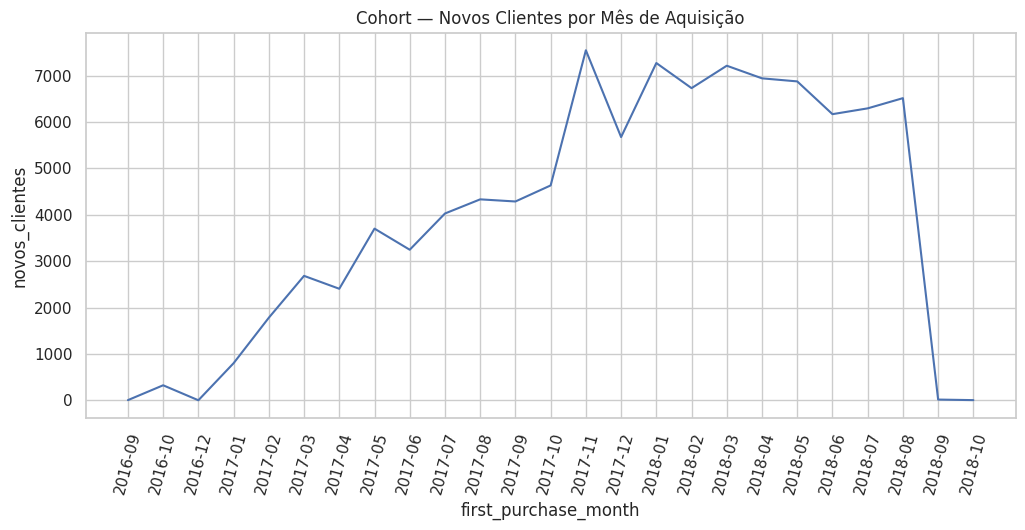

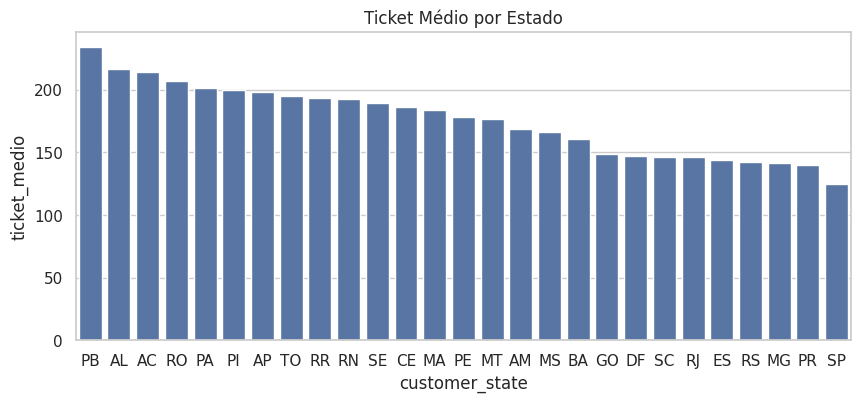

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dashboard HTML gerado com sucesso!


In [1]:
# ============================================================
# OLIST ANALYTICS
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io, zipfile

sns.set(style="whitegrid")

# --------------------------------------------
# UPLOAD DO ARQUIVO ZIP COM AS BASES
# --------------------------------------------
print("Faça upload do arquivo ZIP contendo os CSVs da base Olist:")
uploaded = files.upload()

zip_name = next(iter(uploaded))
zf = zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), "r")

# extração
zf.extractall("olist_data")

# --------------------------------------------
# CARREGANDO AS BASES
# --------------------------------------------
customers = pd.read_csv("olist_data/olist_customers_dataset.csv")
orders = pd.read_csv("olist_data/olist_orders_dataset.csv")
order_items = pd.read_csv("olist_data/olist_order_items_dataset.csv")
products = pd.read_csv("olist_data/olist_products_dataset.csv")
sellers = pd.read_csv("olist_data/olist_sellers_dataset.csv")

# converter timestamp
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
order_items["price"] = order_items["price"].astype(float)
order_items["freight_value"] = order_items["freight_value"].astype(float)

print("Bases carregadas com sucesso!")

# ============================================================
# 1) ANÁLISE TEMPORAL — Receita ao longo do tempo
# ============================================================
df_time = (
    orders.merge(order_items, on="order_id")
    .assign(
        year=lambda x: x["order_purchase_timestamp"].dt.year,
        month=lambda x: x["order_purchase_timestamp"].dt.month,
        revenue=lambda x: x["price"] + x["freight_value"]
    )
    .groupby(["year", "month"])
    .agg(total_revenue=("revenue", "sum"))
    .reset_index()
)

plt.figure(figsize=(12,5))
plt.plot(df_time["total_revenue"])
plt.title("Receita Total por Mês")
plt.xlabel("Período (linhas ordenadas por ano-mês)")
plt.ylabel("Receita")
plt.show()

df_time.head()

# ============================================================
# 2) RANKING — Top 10 produtos mais vendidos
# ============================================================
df_rank = (
    order_items
        .merge(products, on="product_id", how="left")
        .groupby("product_category_name")
        .agg(qtd_vendida=("order_id", "count"))
        .sort_values("qtd_vendida", ascending=False)
        .head(10)
        .reset_index()
)

plt.figure(figsize=(12,5))
sns.barplot(data=df_rank, x="product_category_name", y="qtd_vendida")
plt.xticks(rotation=70)
plt.title("Top 10 Categorias de Produtos Mais Vendidas")
plt.xlabel("Categoria de Produto")
plt.ylabel("Quantidade Vendida")
plt.show()

df_rank

# ============================================================
# 3) AGREGAÇÃO MULTIDIMENSIONAL — Categoria x Estado
# ============================================================

df_multi = (
    order_items
    .merge(products, on="product_id")
    .merge(orders, on="order_id")
    .merge(customers, on="customer_id")
)

df_multi["ticket"] = df_multi["price"] + df_multi["freight_value"]

df_state_cat = (
    df_multi.groupby(["product_category_name", "customer_state"])
    .agg(
        qtd_vendas=("order_id", "count"),
        ticket_medio=("ticket", "mean")
    )
    .reset_index()
)

# Mostra as primeiras linhas como tabela
print("Tabela Categoria x Estado:")
display(df_state_cat.head(10))


# ============================================================
# 3.1) GRÁFICO — Heatmap de vendas por Categoria x Estado
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot para formar a matriz Estado x Categoria
pivot_df = df_state_cat.pivot_table(
    index="customer_state",
    columns="product_category_name",
    values="qtd_vendas",
    fill_value=0
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, cmap="Blues")
plt.title("Heatmap — Quantidade de vendas por Categoria e Estado")
plt.xlabel("Categoria de Produto")
plt.ylabel("Estado do Cliente")
plt.tight_layout()
plt.show()

# ============================================================
# 4) COHORT — Primeiro mês da compra por cliente (CORRIGIDO)
# ============================================================

orders["first_purchase_month"] = (
    orders.groupby("customer_id")["order_purchase_timestamp"].transform("min")
)

orders["first_purchase_month"] = (
    orders["first_purchase_month"].dt.to_period("M").astype(str)
)

df_cohort = (
    orders.drop_duplicates("customer_id")
    .groupby("first_purchase_month")
    .agg(novos_clientes=("customer_id", "count"))
    .reset_index()
)

df_cohort = df_cohort.sort_values("first_purchase_month")

plt.figure(figsize=(12,5))
sns.lineplot(data=df_cohort, x="first_purchase_month", y="novos_clientes")
plt.title("Cohort — Novos Clientes por Mês de Aquisição")
plt.xticks(rotation=75)
plt.show()

df_cohort

# ============================================================
# 5) KPI — Ticket médio por estado
# ============================================================
df_kpi = (
    order_items
    .merge(orders, on="order_id")
    .merge(customers, on="customer_id")
)

df_kpi["ticket"] = df_kpi["price"] + df_kpi["freight_value"]

df_ticket_estado = (
    df_kpi.groupby("customer_state")
    .agg(
        ticket_medio=("ticket", "mean"),
        qtd_pedidos=("order_id", "count")
    )
    .reset_index()
    .sort_values("ticket_medio", ascending=False)
)

plt.figure(figsize=(10,4))
sns.barplot(data=df_ticket_estado, x="customer_state", y="ticket_medio")
plt.title("Ticket Médio por Estado")
plt.show()

df_ticket_estado
